# NYC Taxi Fare Prediction: Machine Learning Explainability

In this exercise, techniques like **permutation importance**, **partial dependence plots**, and **SHAP values** are used to extract human-understandable insights from machine learning models.

The following insights can be driven by using these methods:
- What features in the were most important in the corresponding model?
- How does each feature affect predictions in a big-picture sense?
- For any single prediction from a model, how did each feature affect that particular prediction?

These insights not only help human understanding of machine learning models but also help find directions for model improvements.

### Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [3]:
data = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows=50000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


### Remove Data with Extreme Outlier Coordinates and Negative Fare

In [6]:
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )
data.reset_index(inplace = True)

data.describe()

,index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000
mean,25018.790501,8.483093,-73.976860,40.756917,-73.975342,40.757473,1.656141
std,14450.013745,4.628164,0.014635,0.018170,0.015917,0.018661,1.284899
min,2.000000,0.010000,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,12427.000000,5.500000,-73.988039,40.744947,-73.987125,40.745922,1.000000
50%,25049.000000,7.500000,-73.979691,40.758027,-73.978547,40.758559,1.000000
75%,37604.000000,10.100000,-73.967823,40.769580,-73.966435,40.770427,2.000000
max,49999.000000,165.000000,-73.900062,40.799952,-73.900062,40.799999,6.000000


### Assign Target and Feature Columns

In [7]:
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

X = data[base_features]
y = data['fare_amount']

### Train/Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [9]:
X_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,25031.000000,25031.000000,25031.000000,25031.000000,25031.000000
mean,-73.976853,40.756905,-73.975347,40.757420,1.661819
std,0.014656,0.018183,0.015944,0.018662,1.289688
min,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,-73.988029,40.744893,-73.987133,40.745741,1.000000
50%,-73.979690,40.758032,-73.978577,40.758512,1.000000
75%,-73.967828,40.769552,-73.966447,40.770421,2.000000
max,-73.900062,40.799952,-73.900062,40.799999,6.000000


In [10]:
y_train.describe()

count    25031.000000
mean         8.466989
std          4.575291
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        165.000000
Name: fare_amount, dtype: float64

### Build Baseline RF
In this project, we will focus on model explainability techniques rather than building and optimizing the model. So here we just use a simple random forest model to keep it easy.

In [11]:
from sklearn.ensemble import RandomForestRegressor

baseline_rf = RandomForestRegressor(n_estimators=50, random_state=1).fit(X_train, y_train)

### Permutation Importance
Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions. Thus, permutation importance gives us **what features have the biggest impact on predictions**, or **feature importance**. 

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(baseline_rf, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = base_features)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight,Feature
0.7866 ± 0.0531,dropoff_latitude
0.7782 ± 0.0736,pickup_latitude
0.5114 ± 0.0313,pickup_longitude
0.4751 ± 0.0361,dropoff_longitude
-0.0022 ± 0.0018,passenger_count


The values towards the top are the most important features, and those towards the bottom matter least. The first number in each row shows how much model performance decreased with a random shuffling.

In the example above, we can tell while **pick up locations** and **drop off locations** are all important features, passenger count does not have much importance in the model.

Also, it seems that **latitude have more importance than longitude**: 
- It might be that travel might be longer in latitude distances than longitude distances in general. Given the shape of NYC which is vertically long, this assumption makes sense.
- It could also be that tolls might be more expensive on vertical roads than horizontal roads.
- Another possibility is that the pricing may vary by different parts of the city.

### Partial Dependence Plots
While feature importance shows what variables most affect predictions, partial dependence plots show **how a feature affects predictions**. Partial dependence plots repeatedly alter the value for one variable to make a series of predictions and trace out predicted outcomes.

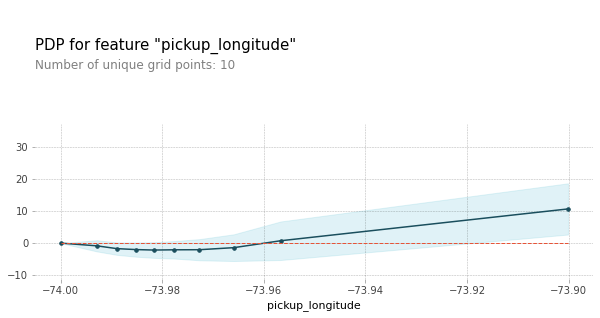

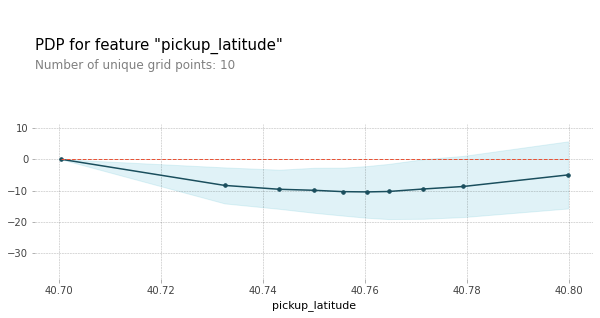

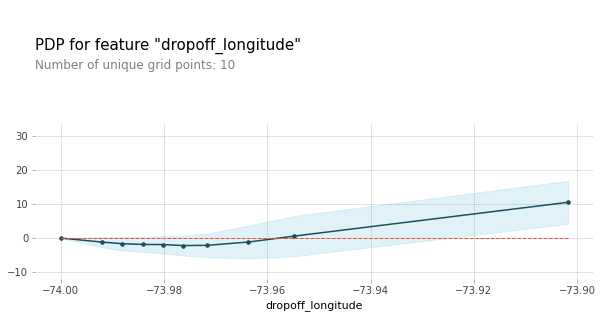

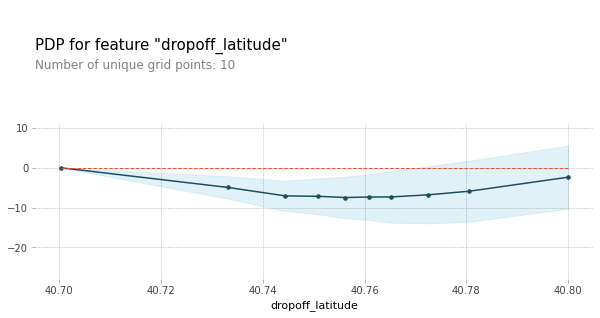

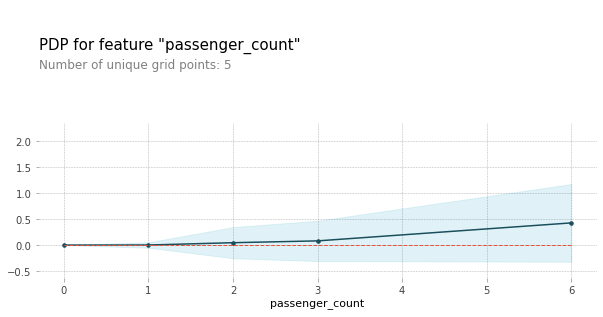

In [32]:
from pdpbox import pdp, get_dataset, info_plots

for feature in base_features:
    pdp_dist = pdp.pdp_isolate(model=baseline_rf, dataset=X_test, model_features=base_features, feature=feature)
    pdp.pdp_plot(pdp_dist,feature, figsize=(10,5))
    plt.show()

#### We have a sense from the permutation importance results that distance is the most important determinant of taxi fare.

This model didn't include distance measures (like absolute change in latitude or longitude) as features, so coordinate features (like pickup_longitude) capture the effect of distance. Being picked up near the center of the longitude values lowers predicted fares on average, because it means shorter trips (on average).

For the same reason, we see the general U-shape in all our partial dependence plots for latitude/longitude.

#### We can also observe that the number of passengers is positively related to the fare. In the results from permutation importance, we saw that the number of passengers have very low feature importance:

- Positive relationship between a feature and target does not necessarily indicate high permutation importance.
- If the data for the feature does not vary much, shuffling would not make much change in the data. Thus permutation importance would be low.
- We can observe from the graph for passenger count that up to 3 passengers, the fare does not increase very much, so if a majority of the data indicate number of passengers less than 4, it would not make much impact on the fare.
- From the histogram below, we can see that the majority of the numer of passengers is 1.
- Also, the slope of the relationship is gradual. Although there seems to be a positive relationship between the feature and the target, the impact can be small.

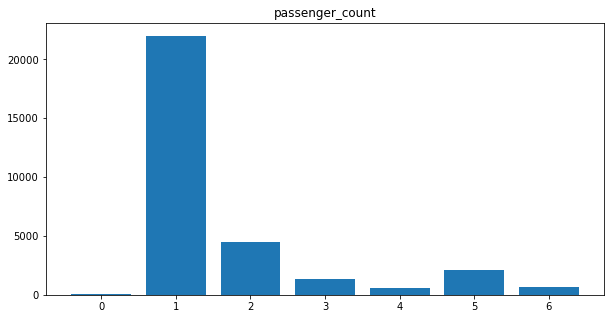

In [31]:
passenger_value_cnt = data['passenger_count'].value_counts(sort=False)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(passenger_value_cnt.index, passenger_value_cnt)
ax.set_title('passenger_count');

### 2D Partial Dependence Plots

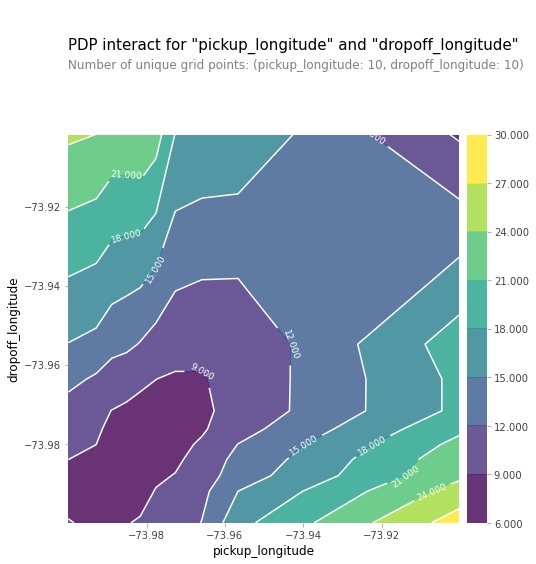

In [15]:
inter_long  =  pdp.pdp_interact(model=baseline_rf, dataset=X_test, model_features=base_features, features=['pickup_longitude','dropoff_longitude'])

pdp.pdp_interact_plot(pdp_interact_out=inter_long, feature_names=['pickup_longitude','dropoff_longitude'], plot_type='contour')
plt.show()

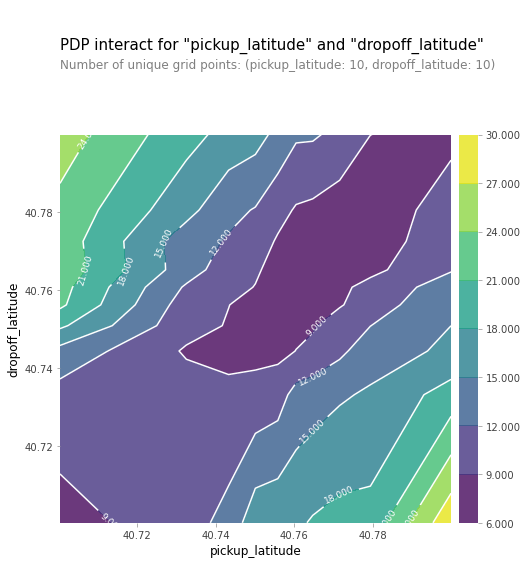

In [16]:
inter_lat  =  pdp.pdp_interact(model=baseline_rf, dataset=X_test, model_features=base_features, features=['pickup_latitude','dropoff_latitude'])

pdp.pdp_interact_plot(pdp_interact_out=inter_lat, feature_names=['pickup_latitude','dropoff_latitude'], plot_type='contour')
plt.show()

Diagonal contours are expected to be seen in the above plots because these are pairs of values where the pickup and dropoff longitudes/latitudes are nearby, indicating shorter trips (controlling for other factors). Prices are expected to increase as you get further from the central diagonal, as the distances between the pickup and dropoff longitudes/latitudes also increase.

While we can see that trend in the above plots, we can also see that prices increase as you go further to the upper-right of the longitude graph, and as you go to the lower-left of the latitude graph.

This could be worth further investigation, though the effect is small compared to moving away from the central diagonal line.

### Add New Features
New features are created based on the results and insights above. The new features are **longitude/latitude distances**.

In [55]:
data['abs_lon_dist'] = abs(data['dropoff_longitude'] - data['pickup_longitude'])
data['abs_lat_dist'] = abs(data['dropoff_latitude'] - data['pickup_latitude'])
data.head()

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lon_dist,abs_lat_dist
0,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
1,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
2,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754
3,6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,0.006200,0.013180
4,7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,0.038795,0.023090


In [18]:
data.describe()

,index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lon_dist,abs_lat_dist
count,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000
mean,25018.790501,8.483093,-73.976860,40.756917,-73.975342,40.757473,1.656141,0.013039,0.014893
std,14450.013745,4.628164,0.014635,0.018170,0.015917,0.018661,1.284899,0.011644,0.012234
min,2.000000,0.010000,-73.999999,40.700013,-73.999999,40.700020,0.000000,0.000000,0.000000
25%,12427.000000,5.500000,-73.988039,40.744947,-73.987125,40.745922,1.000000,0.004947,0.006038
50%,25049.000000,7.500000,-73.979691,40.758027,-73.978547,40.758559,1.000000,0.010049,0.011670
75%,37604.000000,10.100000,-73.967823,40.769580,-73.966435,40.770427,2.000000,0.017717,0.020497
max,49999.000000,165.000000,-73.900062,40.799952,-73.900062,40.799999,6.000000,0.094065,0.094655


### Build the Model Using New Features
Since we only have seven features includeing the new features here, we'll keep all features. When there are too many features and the computational expense is high or when we are working with models that are more likely to overfit, we can use the above technique and insights for **feature selection**.

In [19]:
features_2 = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'passenger_count',
               'abs_lat_dist',
               'abs_lon_dist']

X = data[features_2]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.2, random_state=1)
second_rf = RandomForestRegressor(n_estimators=30, random_state=1).fit(X_train_2, y_train_2)

### Permutation Importance for the New Model

In [20]:
perm_2 = PermutationImportance(second_rf, random_state=1).fit(X_test_2, y_test_2)
eli5.show_weights(perm_2, feature_names = features_2)

Weight,Feature
0.5487 ± 0.0316,abs_lat_dist
0.3940 ± 0.0505,abs_lon_dist
0.0641 ± 0.0096,dropoff_latitude
0.0551 ± 0.0242,pickup_longitude
0.0511 ± 0.0181,pickup_latitude
0.0352 ± 0.0136,dropoff_longitude
-0.0004 ± 0.0032,passenger_count


While both features for distances had higher feature importances than location features, latitude distances are more important than longitude distances. This does **not** give us information on whether traveling a fixed latitudinal distance is more or less expensive than traveling the same longitudinal distance.

Possible reasons latitude feature are more important than longitude features:

- Latitudinal distances in the dataset tend to be larger
- It is more expensive to travel a fixed latitudinal distance
- Both of the above

### Changes in Partial Dependence Plots

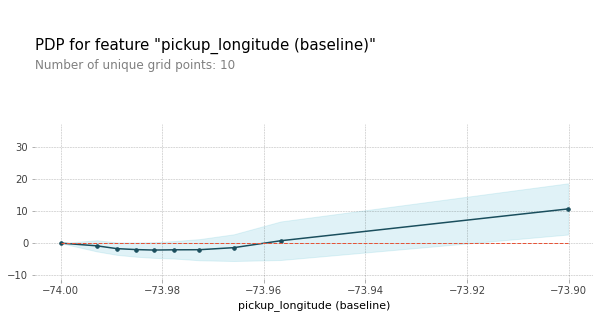

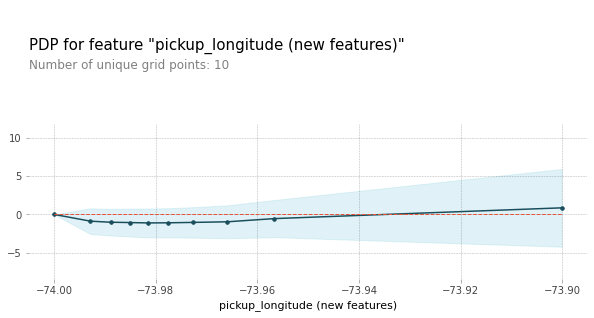

In [33]:
pdp_dist = pdp.pdp_isolate(model=baseline_rf, dataset=X_test, model_features = base_features, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'pickup_longitude (baseline)', figsize=(10,5))
plt.show()

pdp_dist = pdp.pdp_isolate(model=second_rf, dataset=X_test_2, model_features = features_2, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'pickup_longitude (new features)', figsize=(10,5))
plt.show()

From the graph above, we can see that the slope of the partial dependence plot became much gradual. Once you control for absolute distance traveled, the pickup_longitude has only a very small impact on predictions. We can see the same trend in the other variables below.

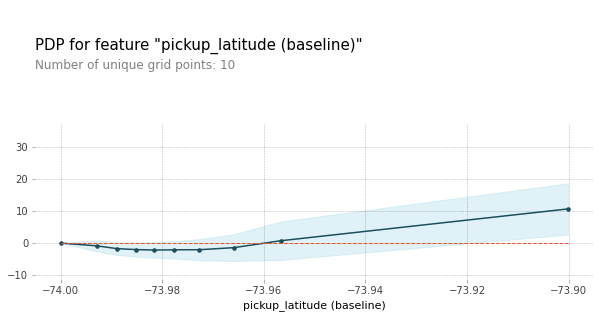

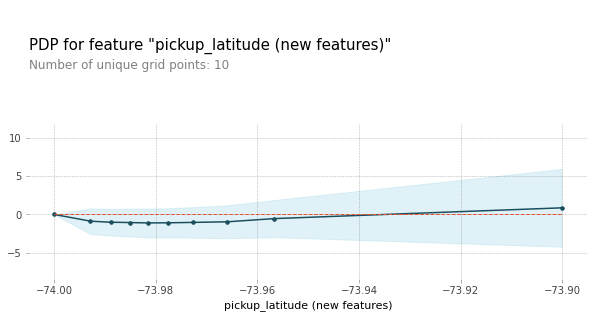

In [34]:
pdp_dist = pdp.pdp_isolate(model=baseline_rf, dataset=X_test, model_features = base_features, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'pickup_latitude (baseline)', figsize=(10,5))
plt.show()

pdp_dist = pdp.pdp_isolate(model=second_rf, dataset=X_test_2, model_features = features_2, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'pickup_latitude (new features)', figsize=(10,5))
plt.show()

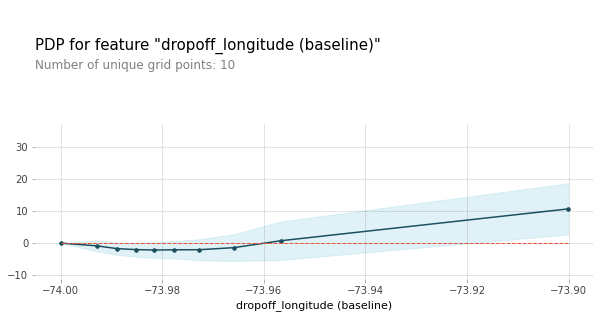

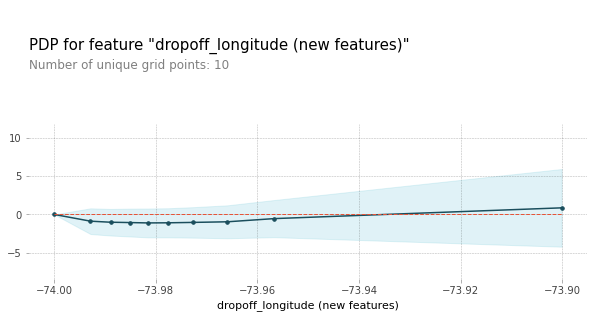

In [35]:
pdp_dist = pdp.pdp_isolate(model=baseline_rf, dataset=X_test, model_features = base_features, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'dropoff_longitude (baseline)', figsize=(10,5))
plt.show()

pdp_dist = pdp.pdp_isolate(model=second_rf, dataset=X_test_2, model_features = features_2, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'dropoff_longitude (new features)', figsize=(10,5))
plt.show()

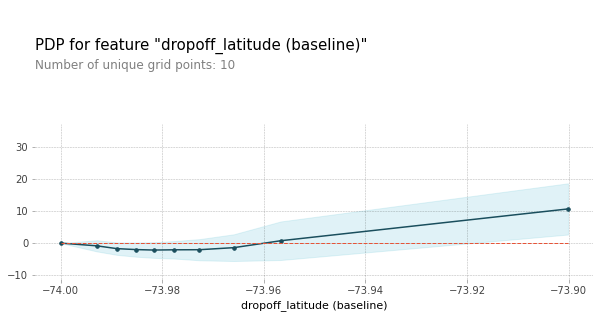

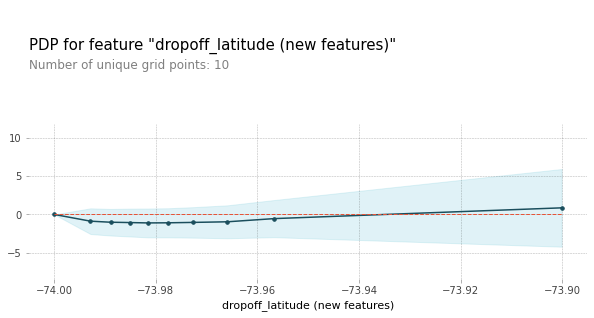

In [36]:
pdp_dist = pdp.pdp_isolate(model=baseline_rf, dataset=X_test, model_features = base_features, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'dropoff_latitude (baseline)', figsize=(10,5))
plt.show()

pdp_dist = pdp.pdp_isolate(model=second_rf, dataset=X_test_2, model_features = features_2, feature='pickup_longitude')
pdp.pdp_plot(pdp_dist, 'dropoff_latitude (new features)', figsize=(10,5))
plt.show()

### Partial Dependence Plots for New Features
The relationships are both positive. We can also see that the slope is steeper for latitude distance, which indicates it costs more to travel a fixed latitudinal distance than traveling the same longitudinal distance.

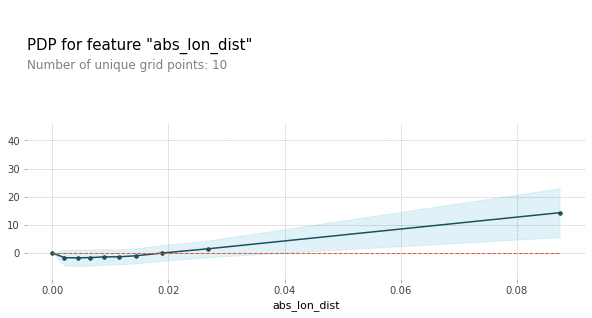

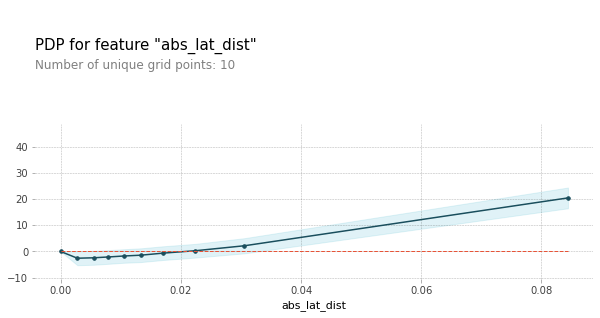

In [37]:
pdp_dist = pdp.pdp_isolate(model=second_rf, dataset=X_test_2, model_features = features_2, feature='abs_lon_dist')
pdp.pdp_plot(pdp_dist, 'abs_lon_dist', figsize=(10,5))
plt.show()

pdp_dist = pdp.pdp_isolate(model=second_rf, dataset=X_test_2, model_features = features_2, feature='abs_lat_dist')
pdp.pdp_plot(pdp_dist, 'abs_lat_dist', figsize=(10,5))
plt.show()

### SHAP Values
We have extracted general insights from the model. Let's now break down **how the model works for each individual prediction**. SHAP vaue is an estimate of the impact of a given feature on the prediction; it interprets the impact of having certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

The by_passenger_factors function creates a visualization of SHAP values by doing the following:

- Takes a single row with passenger data (of the same format you as raw data).
- Creates a visualization showing what features of that passenger increased/decreased the fare and how much those features mattered.

It's not important to show every feature with every miniscule impact on the fare.  It's fine to focus on only the most important features.

In [26]:
# Use SHAP values to show the effect of each feature of a given passenger

import shap  # package used to calculate Shap values

sample_data_p1 = X_test_2[X_test_2['passenger_count']==1].iloc[0].astype(float)
sample_data_p6 = X_test_2[X_test_2['passenger_count']==6].iloc[0].astype(float)

def by_passenger_factors(model, ride_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(ride_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values, ride_data)

In [27]:
by_passenger_factors(second_rf, sample_data_p1)

<img src="https://github.com/jiyoungsim/NYC-Taxi-Fare-Prediction--ML-Explainability/figs/SHAP1.png?raw=true">

In [28]:
by_passenger_factors(second_rf, sample_data_p6)

<img src="https://github.com/jiyoungsim/NYC-Taxi-Fare-Prediction--ML-Explainability/figs/SHAP2.png?raw=true">

Let's take one example of one-passenger ride and one example of six-passenger-ride. As we saw from partial dependence plots, we can see that for one-passenger ride the number of passengers have minimal importance. However, in six-passenger ride, the number of passengers had the highest positive impact. Like this, **a feature that has low impact in the overall prediction power might have high impact in individual prediction point**.

We observed that latitude distance had more impact on overall predictions in the section above. While in the first example the latitude distance have more impact on the prediction, in the second example the longitude distance had more impact, unlike in the analysis for overall prediction power. **Feature importances and impacts on each individual prediction do not necessarily reflect what the features do to the overall prediction**.

Due to these reasons, analyzing individual predictions may also be important depending on the purpose of the model. For example, the insights from this section can be valuable to companies in mobility industry that provide personalized services to each customer.



### SHAP Summary Plots
SHAP summary plots give us a birds-eye view of feature importance and what is driving it. Each dot has the following characteristics:
- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

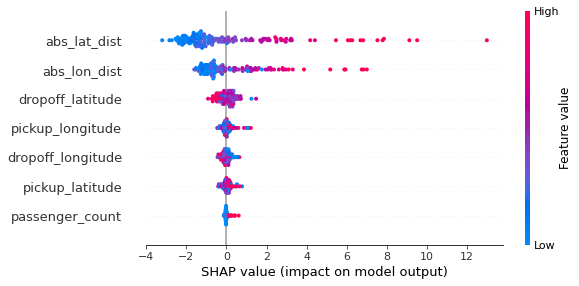

In [41]:
# For speed, we will calculate shap values on smaller subset of the validation data
small_X_test = X_test_2.iloc[:150]

explainer = shap.TreeExplainer(second_rf)
shap_values = explainer.shap_values(small_X_test)

shap.summary_plot(shap_values, small_X_test)

Here, the longitude/latitude distance features are the most widely spread. In these features, points with low feature values have low SHAP values, while points with high feature values have high SHAP values. The width of the effects range is not a reasonable approximation to permutation importance. For that matter, the width of the range doesn't map well to any intuitive sense of "importance" because it can be determined by just a few outliers. However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high. Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.

While in some features we can see reasonably clear separation between the blue and pink dots, in other variables dots are jumbled together. This suggests that sometimes increasing that feature leads to higher predictions, and other times it leads to a lower prediction. The most likely explanation for this effects is that the variable has an interaction effect with other variables.

### SHAP Dependence Contribution Plots
Using SHAP Dependence Contribution Plots, we can not only observe the relationship between SHAP value for a feature and the feature but also **interactions** a feature has with other features.

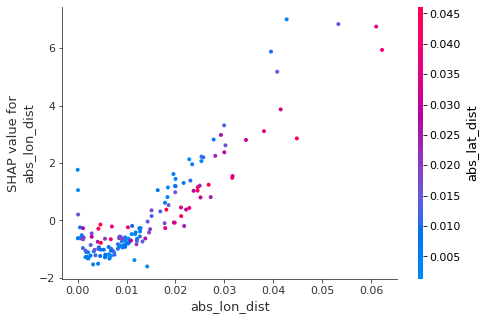

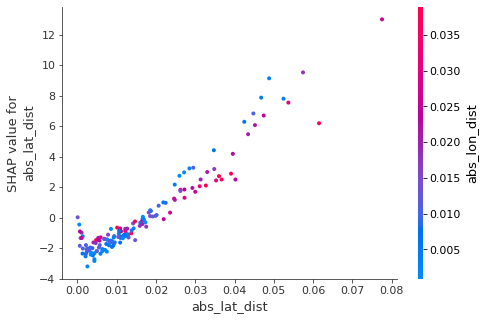

In [62]:
shap.dependence_plot('abs_lon_dist', shap_values, small_X_test)
shap.dependence_plot('abs_lat_dist', shap_values, small_X_test)

The graphs slope upward, meaning the larger the distance, the higher the model's prediction for fare is. The graphs also suggest feature interactions. We can see from the first graph that when the longitude distance is small, SHAP value for longitude distance does not show much difference whether the latitude distance is large/small. However, when the longitude distance is large, there is a slight tendency of fare predictions being larger when latitude distance is smaller. Similar tendency shows in the second graph as well, although it is less obvious than in the first graph.